In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import pymc3.math as pmath
import scipy.stats as stats
import statsmodels.api as sm

import matplotlib.pyplot as graph
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from patsy import dmatrices


sns.set(font_scale=1.25, rc={'figure.figsize': (12, 5)})

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/home/stephen/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/stephen/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/stephen/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/stephen/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
graph.style.use('fivethirtyeight')

In [3]:
data = pd.read_csv('data/education.income.csv')

sex_encoder = LabelEncoder().fit(data['sex'])
data['sex_code'] = sex_encoder.transform(data['sex'])

data = data[['height', 'weight', 'sex', 'sex_code']]
display(data.head())
print(data.shape)

,height,weight,sex,sex_code
0,60,155.0,female,0
1,70,156.0,female,0
2,65,195.0,male,1
3,63,197.0,female,0
4,66,190.0,male,1


(7006, 4)


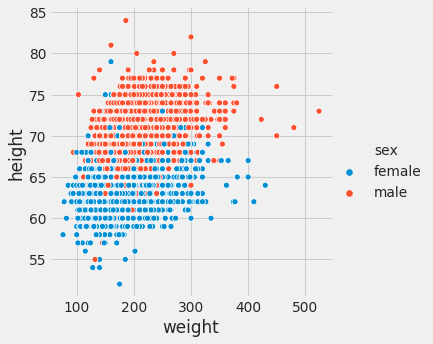

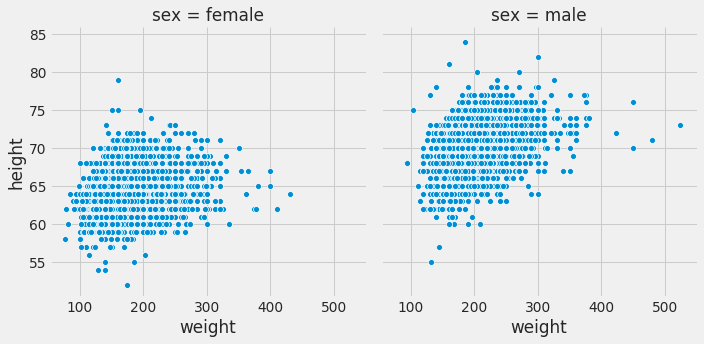

In [4]:
sns.relplot(x='weight', y='height', data=data, hue='sex')
graph.show()

sns.relplot(x='weight', y='height', data=data, col='sex')
graph.show()

# Modelling

In [5]:
y, x = dmatrices('sex_code ~ weight + height', data.sample(2000), return_type='dataframe')
y = y.values.flatten()

display(x.head())
print(y.shape, x.shape)

,Intercept,weight,height
3771,1.0,235.0,64.0
5635,1.0,160.0,74.0
2971,1.0,200.0,68.0
207,1.0,179.0,67.0
4063,1.0,140.0,63.0


(1974,) (1974, 3)


In [6]:
# Statsmodel version
freq = sm.GLM(y, x, family=sm.families.Binomial()).fit()
display(freq.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1974
Model:                            GLM   Df Residuals:                     1971
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -700.82
Date:                Fri, 03 Aug 2018   Deviance:                       1401.6
Time:                        21:18:19   Pearson chi2:                 3.15e+03
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -45.5814      1.991    -22.895      0.000     -49.483     -41.679
weight         0.0016      0.002      0.892      0.373      -0.002       0.005
height         0.6741      0.031     22.046      0.000       0.614       0.734
==============================================================================
"""

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m]
Sampling 4 chains: 100%|██████████| 24000/24000 [02:56<00:00, 136.18draws/s]


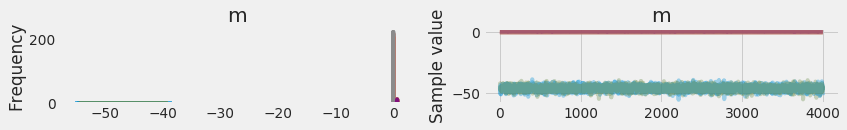

CPU times: user 7.94 s, sys: 1.24 s, total: 9.19 s
Wall time: 2min 59s


In [7]:
%%time
with pm.Model() as model:
    # Priors
    m = pm.Normal('m', mu=0, sd=100**2, shape=(x.shape[1],))
    
    # Likelihood:
    obs = pm.Bernoulli('obs', p=pmath.sigmoid(pmath.dot(x, m)), observed=y, total_size=len(y))
    
    # Sample
    trace = pm.sample(4000, tune=2000)
    
    pm.traceplot(trace)
    graph.show()

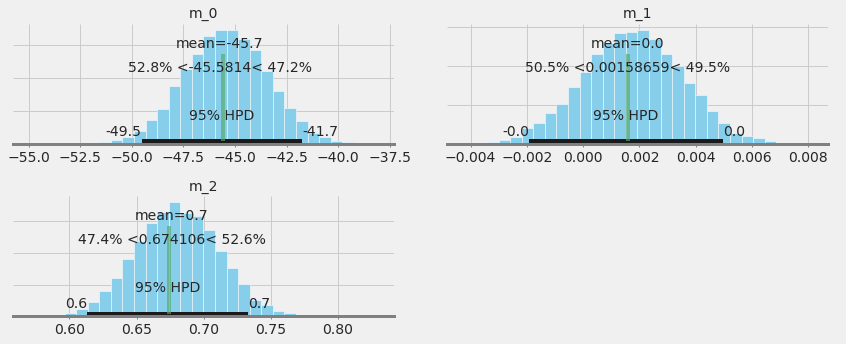

In [12]:
pm.plot_posterior(trace, ref_val=freq.params.values, round_to=1)
graph.show()

# Results

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

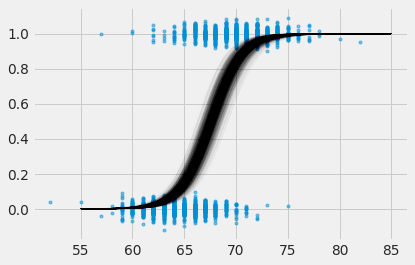

In [10]:
jitter = stats.norm(0, 0.03).rvs(y.shape)
xs = np.linspace(55, 85, 1000)

graph.plot(x['height'], y + jitter, '.', alpha=0.5)
for _, t in pm.trace_to_dataframe(trace[-500:]).iterrows():
    graph.plot(xs, sigmoid((t['m__2'] * xs) + t['m__0']), linewidth=1, color='black', alpha=0.01)
graph.show()

 Done!
 
 _Stephen Anthony Rose_